## Load Libraries

In [1]:
import os
import cv2
import math
import pickle
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import skimage.measure
import matplotlib.pyplot as plt

from glob import glob
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import greycomatrix, greycoprops
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, accuracy_score
%matplotlib inline

## Display Image

In [2]:
def display_img(img):
    plt.imshow (img, interpolation = 'nearest')
    _ = plt.axis(False)

## Load Model

In [3]:
model_path = "Models\\\\"
filename_arr = ["rf", "svm","knn"]

In [4]:
model_arr = [pickle.load(open(f"{model_path}{filename}_model.sav", 'rb')) for filename in filename_arr]

rf_model = model_arr[0]
svm_model = model_arr[1]
knn_model = model_arr[2]

## Test Image

### Remove White Background (Threshold)

In [5]:
def remove_background(img, threshold):
    """
    This method removes background from your image
    
    :param img: cv2 image
    :type img: np.array
    :param threshold: threshold value for cv2.threshold
    :type threshold: float
    :return: RGBA image
    :rtype: np.ndarray
    """
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, threshed = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY_INV)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)
    
    cnts = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    cnt = sorted(cnts, key=cv2.contourArea)[-1]

    mask = cv2.drawContours(threshed, cnt, 0, (0, 255, 0), 0)
    masked_data = cv2.bitwise_and(img, img, mask=mask)

    x, y, w, h = cv2.boundingRect(cnt)
    dst = masked_data[y: y + h, x: x + w]

    dst_gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    _, alpha = cv2.threshold(dst_gray, 0, 255, cv2.THRESH_BINARY)
    b, g, r = cv2.split(dst)

    rgba = [r, g, b, alpha]
    dst = cv2.merge(rgba, 4)
    
    dst = cv2.cvtColor(dst, cv2.COLOR_BGRA2RGB)

    return dst

### Conversion Function

#### Convert Val To RGB

In [6]:
def convert_val_to_rgb(x):
    if x >= 0 and x < 64:
        return "00"
    elif x >= 64 and x < 128:
        return "55"
    elif x >= 128 and x < 192:
        return "AA"
    else:
        return "FF"

#### Convert Val To Bin

In [7]:
def convert_val_to_bin(x):
    if x >= 0 and x < 64:
        return 0
    elif x >= 64 and x < 128:
        return 85
    elif x >= 128 and x < 192:
        return 170
    else:
        return 255

### Pipeline Color Features

In [8]:
def pipeline_color(cv_img):
    img_arr = np.array(cv_img)
    img_flatten = img_arr.reshape(1, -1).T
    img_squeeze = np.squeeze(img_flatten)
    img_convert = np.vectorize(convert_val_to_rgb)(img_squeeze)
    img_2d_arr = img_convert.reshape(-1, 3)
    img_list_arr = img_2d_arr.tolist()
    convert_to_str = lambda x:"#"+"".join(list(map(str, x)))
    img_str_arr = [convert_to_str(x) for x in img_list_arr]
    new_arr = np.array(img_str_arr)
    tmp_dict = {a:b for (a,b) in zip(np.unique(new_arr, return_counts=True)[0], np.unique(new_arr, return_counts=True)[1])}
    return tmp_dict

### Pipeline Texture Features

In [9]:
def pipeline_texture(img_gray):
    tmp_dict = {}
    tmp_dict["Mean"] = np.mean(img_gray)
    tmp_dict["Variance"] = np.var(img_gray)
    tmp_dict["Entropy"] = skimage.measure.shannon_entropy(img_gray)
    glcm = greycomatrix(img_gray, [2], [0], 256, symmetric = True, normed = True)
    tmp_dict["Contrast"] = greycoprops(glcm, prop="contrast").item()
    tmp_dict["Homogeneity"] = greycoprops(glcm, prop="homogeneity").item()
    tmp_dict["Correlation"] = greycoprops(glcm, prop="correlation").item()
    tmp_dict["Energy"] = greycoprops(glcm, prop="energy").item()
    return tmp_dict

### Pipeline Shape Features

In [10]:
def pipeline_shape(img_gray):
    # Apply Gaussian Blur to Image
    img_blur = cv2.GaussianBlur(img_gray, (7,7), 1)

    # Canny Edge Detection
    img_canny = cv2.Canny(img_blur, 50, 150)

    # Edge Detector
    kernel = np.ones((5, 5), dtype = np.uint8)
    img_dilate = cv2.dilate(img_canny, kernel, iterations = 2)

    contours, hier = cv2.findContours(img_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    area, peri = 0, 0
    mu, huMoments = [], []
    
    for cnt in contours:
        area = cv2.contourArea(cnt)
        peri = cv2.arcLength(cnt, True)
        mu = cv2.moments(cnt)
        huMoments = cv2.HuMoments(mu)
        
    for i in range(0,7):
        huMoments[i] = -1* math.copysign(1.0, huMoments[i]) * math.log10(abs(huMoments[i]) if abs(huMoments[i]) > 0 else 1)
    
    tmp_dict = {}
    tmp_dict["Area"] = area
    tmp_dict["Perimeter"] = peri
    for (i, huMoment) in enumerate(huMoments):
        tmp_dict[f"huMoment {(i + 1)}"] = huMoment[0]
    return tmp_dict

### Pipeline Final

In [11]:
def pipeline_img(img_path, threshold = 225, h = 100, w = 100):
    cv_img = cv2.imread(img_path)
    
    # Resize Image
    cv_img = cv2.resize(cv_img, (w,h),interpolation = cv2.INTER_AREA)
    
    # Remove White Background
    cv_img = remove_background(cv_img, threshold)
    
    # Convert Image from RGB to BGR
    cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    
    # Transform CV Image from unint8 to float32
    img_tmp = cv_img / 255.0
    
    # Color Enhancement - Enhance the R, G, B Colors of the image
    r, g, b = cv2.split(img_tmp)
    img_sum = r + g + b
    CR, CG, CB = cv2.divide(r, img_sum), cv2.divide(g, img_sum), cv2.divide(b, img_sum)
    img_tmp = cv2.merge((CR, CG, CB))
    
    # Convert the image from float32 to uint8
    img_tmp = np.uint8(img_tmp * 255)
    
    # Convert the image to Gray Image
    img_gray = cv2.cvtColor(img_tmp, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian Blur to Image
    img_blur = cv2.GaussianBlur(img_gray, (7,7), 1)
    
    # Canny Edge Detection
    img_canny = cv2.Canny(img_blur, 50, 150)
    
    # Edge Detector
    kernel = np.ones((5, 5), dtype = np.uint8)
    img_dilate = cv2.dilate(img_canny, kernel, iterations = 1)
    
    contours, hier = cv2.findContours(img_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Crop the Image
    roi = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        roi = cv_img[y: y + h, x: x + w]
        
    # Darken Image
    roi = cv2.convertScaleAbs(roi, alpha=0.75, beta=20)
    return roi

In [12]:
def pipeline_all_dict(cv_img):
    final_dict = {}
    
    # Get Color Features
    color_feature_dict = pipeline_color(cv_img)
    final_dict.update(color_feature_dict)
    
    # Convert Image to Gray Image
    img_gray = cv2.cvtColor(cv_img, cv2.COLOR_RGB2GRAY)

    # Get Texture Features
    texture_feature_dict = pipeline_texture(img_gray)
    final_dict.update(texture_feature_dict)

    # Get Shape Features
    shape_feature_dict = pipeline_shape(img_gray)
    final_dict.update(shape_feature_dict)
    
    return final_dict

In [13]:
def pipeline_final(img_path):
    cv_img = pipeline_img(img_path)
    final_dict = pipeline_all_dict(cv_img)
    return final_dict

In [14]:
feature_arr = []

cc = ["00", "55", "AA", "FF"]

# Color Features
for i in cc:
    for j in cc:
        for k in cc:
            feature_arr.append(f"#{i}{j}{k}")

# Texture Feature
feature_arr += ["Mean", "Variance", "Entropy", "Contrast", "Homogeneity", "Correlation", "Energy"]

# Shape Feature
feature_arr += [f"huMoment {(i + 1)}" for i in range(7)]
feature_arr += ["Area", "Perimeter"]

## Predict Image in To_Predict Folder

In [15]:
to_predict_img_path = "To_Predict"

### Get List of Images from To_Predict Folder

In [16]:
def get_list_of_image_from_to_predict(default_prediction_folder_path = "To_Predict"):
    arr = glob(default_prediction_folder_path + "\\*.jpg")
    return arr

### Use Random Forest Model To Predict Individual Image

In [17]:
def pred_img(model, img_path):
    # Feature Array
    feature_arr = []
    cc = ["00", "55", "AA", "FF"]

    for i in cc:
        for j in cc:
            for k in cc:
                feature_arr.append(f"#{i}{j}{k}")

    feature_arr += ["Mean", "Variance", "Entropy", "Contrast", "Homogeneity", "Correlation", "Energy"]
    feature_arr += [f"huMoment {(i + 1)}" for i in range(7)]
    feature_arr += ["Area", "Perimeter"]
    
    # Generate DataFrame
    final_df = pd.DataFrame(columns = feature_arr)
    final_dict = pipeline_final(img_path)
    final_df = final_df.append(final_dict, ignore_index = True)
    final_df.fillna(0, inplace=True)
    final_df = final_df.iloc[:,:64]
    
    pred_label = model.predict(final_df)
    return pred_label[0]

### Make Predictions

### Predict against one Single Fruit

Predicted Fruit label: Lychee


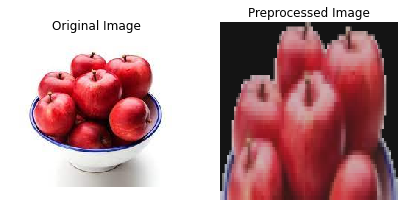

In [18]:
selected_img_path = 'To_Predict\\rand_img_1.jpg'

ori_img = cv2.imread(selected_img_path)
ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)

preprocessed_img = pipeline_img(selected_img_path)
preprocessed_img = cv2.resize(preprocessed_img, (100, 100), interpolation = cv2.INTER_AREA)

img_arr = [ori_img, preprocessed_img]
img_name_arr = ["Original Image", "Preprocessed Image"]

# Show Predicted Result
pred_label = pred_img(rf_model, selected_img_path)
            
fig, axs = plt.subplots(1, 2, figsize=(7, 7))
print(f"Predicted Fruit label: {pred_label}")
            
for i in range(0, 2):
    axs[i].imshow(img_arr[i], interpolation = 'nearest')
    axs[i].axis("off")
    axs[i].set_title(img_name_arr[i])

### Predict Against all fruit Image in To_Predict Folder

In [19]:
fruit_img_path_arr = get_list_of_image_from_to_predict(to_predict_img_path)
fruit_img_path_arr

['To_Predict\\rand_img_1.jpg',
 'To_Predict\\rand_img_2.jpg',
 'To_Predict\\rand_img_3.jpg',
 'To_Predict\\rand_img_4.jpg',
 'To_Predict\\rand_img_5.jpg',
 'To_Predict\\rand_img_6.jpg',
 'To_Predict\\rand_img_7.jpg']

Predicted Fruit label: Lychee


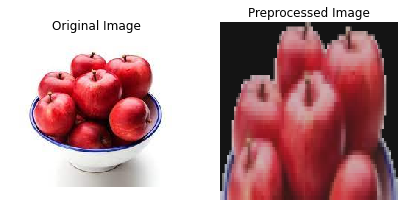

Predicted Fruit label: Grape


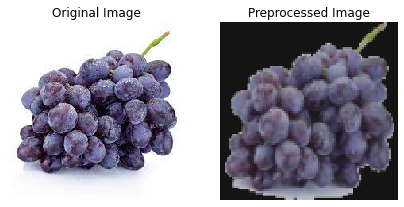

Predicted Fruit label: Lemon


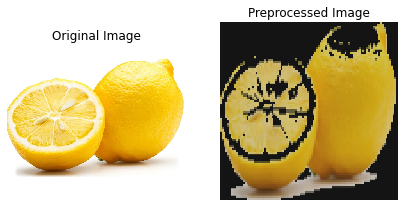

Predicted Fruit label: Limes


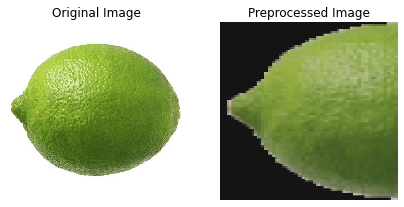

Predicted Fruit label: Apple


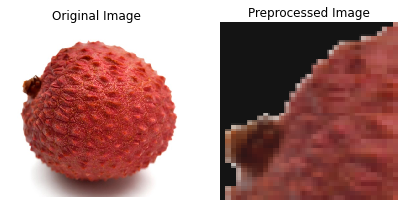

Predicted Fruit label: Lemon


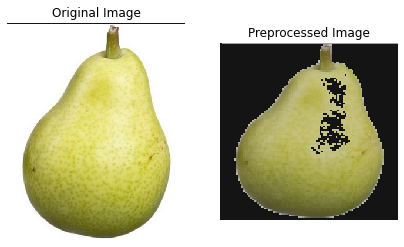

Predicted Fruit label: Pear


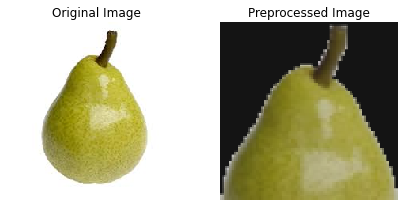

In [20]:
fruit_img_path_arr = get_list_of_image_from_to_predict(to_predict_img_path)
for img_path in fruit_img_path_arr:
    ori_img = cv2.imread(img_path)
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    
    preprocessed_img = pipeline_img(img_path) # Show Preprocessed Images
    preprocessed_img = cv2.resize(preprocessed_img, (100, 100), interpolation = cv2.INTER_AREA) # Resize Preprocessed Image
     
    img_arr = [ori_img, preprocessed_img]
    img_name_arr = ["Original Image", "Preprocessed Image"]
    
    pred_label = pred_img(rf_model, img_path) # Show Predicted Result
            
    fig, axs = plt.subplots(1, 2, figsize=(7, 7))
    print(f"Predicted Fruit label: {pred_label}")
            
    for i in range(0, 2):
        axs[i].imshow(img_arr[i], interpolation = 'nearest')
        axs[i].axis("off")
        axs[i].set_title(img_name_arr[i])
    plt.show()

## Test Image Folder

In [21]:
# test_img_path = "Test_Images"

In [22]:
# plot_img_grid(get_img_arr(test_img_path), 6, 4, (15, 15))

In [23]:
# print("Prediction: ")
# get_pred_df(rf_model, feature_arr, test_img_path)

In [24]:
# get_result_score(rf_model, feature_arr, test_img_path)